# Getting Started

This notebook serves as a simple demonstration for the CRAFT detection model

**IMPORTANT** Please make sure you have uploaded the model weights in the `./weights`  folder

In [1]:
import torch
import torch.backends.cudnn as cudnn
from craft import CRAFT
from refinenet import RefineNet
import cv2
from collections import OrderedDict
import matplotlib.pyplot as plt
import importlib
import inference
importlib.reload(inference)
from inference import draw_boxes, run_craft_inference, merge_boxes

In [2]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

In [3]:
use_cuda = torch.cuda.is_available()
trained_model_path = "./weights/craft_mlt_25k.pth"
refiner_model_path = "./weights/craft_refiner_CTW1500.pth"

In [4]:
detector = CRAFT()
detector.load_state_dict(
    copyStateDict(
        torch.load(trained_model_path, map_location="cuda" if use_cuda else "cpu")
    )
)
detector = detector.cuda() if use_cuda else detector
detector = torch.nn.DataParallel(detector)
cudnn.benchmark = False
detector.eval()

c:\Users\anial\Downloads\capstone-htr\spaniq_toxiq\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anial\Downloads\capstone-htr\spaniq_toxiq\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\anial\AppData\Local\Temp\ipykernel_30268\1895550163.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release,

DataParallel(
  (module): CRAFT(
    (basenet): vgg16_bn(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (slice2): Sequential(


In [5]:
refine_net = RefineNet()
refine_net.load_state_dict(
    copyStateDict(
        torch.load(refiner_model_path, map_location="cuda" if use_cuda else "cpu")
    )
)
refine_net = refine_net.cuda() if use_cuda else refine_net
refine_net = torch.nn.DataParallel(refine_net)
refine_net.eval()

C:\Users\anial\AppData\Local\Temp\ipykernel_30268\1807341758.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(refiner_model_path, map_location="cuda" if use_cu

DataParallel(
  (module): RefineNet(
    (last_conv): Sequential(
      (0): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (aspp1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(128, e

In [6]:
image_path = "../SimpleHTR/data/test_picture.jpg"
img, detected_boxes = run_craft_inference(
    image_path, net=detector, refine_net=refine_net, link_threshold=0.7
)
output_img = draw_boxes(img, detected_boxes)

As you can observe below, the boxes might incorrectly oversegment the word, to avoid that a merging function is used to merge nearby boxes together. It was written to be as accurate as possible, but please note that this model is being used as-is and iits refinement is outside of this project's scope.

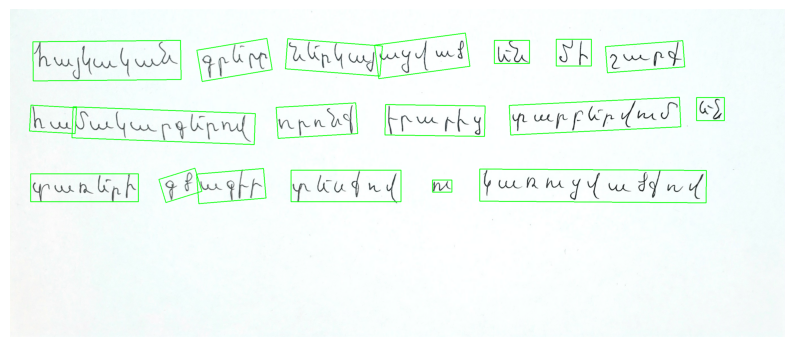

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Postprocessing the detected boxes

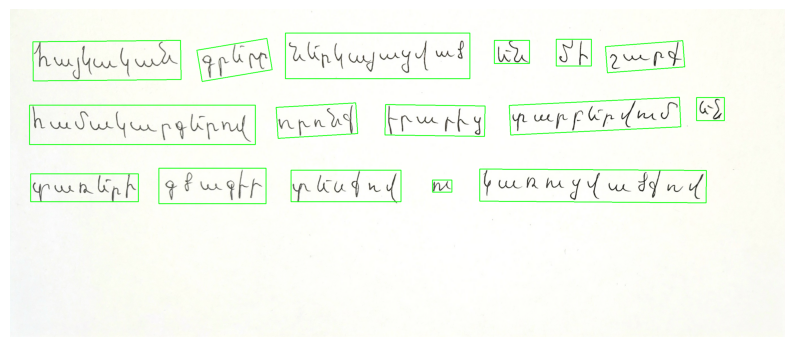

In [8]:
refined_boxes = merge_boxes(detected_boxes)
output_img = draw_boxes(img, refined_boxes)
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.axis("off")
plt.show()